In [1]:

from tqdm import tqdm
import os 
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from sklearn.metrics import mean_squared_error as mse
import numpy as np 
import logging 
from termcolor import colored
import scipy.io as sio
import matplotlib.pyplot as plt 

In [2]:
import numpy as np 
import torch 
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import os 

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class MLPEncoderBlock(nn.Module):
    def __init__(self, input_dim, hidden_dims, latent_dim, activation=nn.ReLU()):
        """_summary_

        Args:
            input_dim (_type_): _description_
            hidden_dims (_type_): _description_
            latent_dim (_type_): _description_
            activation (_type_, optional): _description_. Defaults to nn.ReLU(). Use nn.Identity() for linear activation.
        """
        super(MLPEncoderBlock, self).__init__()
        self.input_dim = input_dim
        self.hidden_dims = hidden_dims
        self.latent_dim = latent_dim
        self.activation = activation
        self.mlp = nn.ModuleList()
        self.mlp.append(nn.Linear(self.input_dim, self.hidden_dims[0]))
        for i in range(1, len(self.hidden_dims)):
            self.mlp.append(nn.Linear(self.hidden_dims[i-1], self.hidden_dims[i]))
        self.latent_map = nn.Linear(self.hidden_dims[-1], self.latent_dim)
    
    def forward(self, x): 
        x = self.mlp[0](x)
        x = self.activation(x)
        for i in range(1, len(self.mlp)):
            x = self.mlp[i](x)
            x = self.activation(x)
        x = self.latent_map(x)
        return x
        
class MLPDecoderBlock(nn.Module):
    def __init__(self, latent_dim, hidden_dims, output_dim, activation=nn.ReLU()):
        super(MLPDecoderBlock, self).__init__()
        self.latent_dim = latent_dim
        self.hidden_dims = hidden_dims
        self.output_dim = output_dim
        self.activation = activation
        self.mlp = nn.ModuleList()
        self.mlp.append(nn.Linear(self.latent_dim, self.hidden_dims[0]))
        for i in range(1, len(self.hidden_dims)):
            self.mlp.append(nn.Linear(self.hidden_dims[i-1], self.hidden_dims[i]))
        self.output_map = nn.Linear(self.hidden_dims[-1], self.output_dim)
    
    def forward(self, z): 
        z = self.mlp[0](z)
        z = self.activation(z)
        for i in range(1, len(self.mlp)):
            z = self.mlp[i](z)
            z = self.activation(z)
        z = self.output_map(z)
        return z
    
    
class CNNEncoderBlock(nn.Module):
    def __init__(self, input_channels, hidden_channels, latent_dim, kernel_sizes, strides, paddings, activation=nn.ReLU()) -> None:
        super().__init__()
        self.activation = activation 
        self.conv = nn.ModuleList()
        self.input_channels = input_channels
        self.latent_dim = latent_dim
        self.hidden_channels = hidden_channels
        self.kernel_sizes = kernel_sizes
        self.strides = strides
        self.paddings = paddings
        self.conv.append(nn.Sequential(nn.Conv2d(self.input_channels, self.hidden_channels[0], self.kernel_sizes[0], self.strides[0], self.paddings[0]),
                                    self.activation,
                                    nn.MaxPool2d(2, 2)))
        for i in range(1, len(self.hidden_channels)):
            self.conv.append(nn.Sequential(nn.Conv2d(self.hidden_channels[i-1], self.hidden_channels[i], self.kernel_sizes[i], self.strides[i], self.paddings[i]),
                                    self.activation,
                                    nn.MaxPool2d(2, 2)))
        self.latent_mlp = nn.Linear(84, self.latent_dim)
        
    def forward(self, x):
        x = self.conv[0](x)
        #print(f"Encode 0 {x.size()}")
        for i in range(1, len(self.conv)):
            x = self.conv[i](x)
            #print(f"Encode {i, x.size()}")
        x = x.view(x.size(0), -1)
        self.input_latent_dim = x.size(1)
        x = self.latent_mlp(x)
        return x
    
class CNNDecoderBlock(nn.Module):
    def __init__(self, latent_dim, hidden_channels, output_channels, kernel_sizes, strides, paddings, activation=nn.ReLU()) -> None:
        super().__init__()
        self.activation = activation 
        self.conv = nn.ModuleList()
        self.latent_dim = latent_dim
        self.hidden_channels = hidden_channels
        self.output_channels = output_channels
        self.kernel_sizes = kernel_sizes
        self.strides = strides
        self.paddings = paddings
        # self.conv.append(nn.Sequential(nn.ConvTranspose2d(self.latent_dim, self.hidden_channels[0], self.kernel_sizes[0], self.strides[0], self.paddings[0]),self.activation))
        for i in range(1, len(self.hidden_channels)):
            self.conv.append(nn.Sequential(self.activation,
                                        nn.ConvTranspose2d(self.hidden_channels[i-1], self.hidden_channels[i], self.kernel_sizes[i], self.strides[i], self.paddings[i]),))
        self.conv.append(nn.Sequential(self.activation,
                                    nn.ConvTranspose2d(self.hidden_channels[-1], self.output_channels, self.kernel_sizes[-1], self.strides[-1], self.paddings[-1])))
        
        if self.latent_dim == 2: 
            self.latent_mlp = nn.Linear(1, 84)
        else:
            self.latent_mlp = nn.Linear(self.latent_dim, 84)
    def forward(self, z):
        z = self.latent_mlp(z)
        z = z.view(z.size(0), self.hidden_channels[0], 7, 3)
        
        z = F.interpolate(z, size=(15,7), mode='nearest')
        z = self.conv[0](z)
        #rint(f"Decode: {0 , z.size()}")
        
        z = F.interpolate(z, size=(31, 15), mode='nearest')
        z = self.conv[1](z)
        #print(f"Decode: {1 , z.size()}")
        
        z = F.interpolate(z, size=(62, 31), mode='nearest')
        z = self.conv[2](z)
        #print(f"Decode: {2 , z.size()}")
        
        z = F.interpolate(z, size=(125, 62), mode='nearest') # Not reverse of maxpooling. Generally upsampling is done by interpolation.
        z = self.conv[3](z)
        #print(f"Decode: {3 , z.size()}")
        
        z = F.interpolate(z, size=(250, 125), mode='nearest')
        z = self.conv[4](z)
        #print(f"Decode: {4 , z.size()}")
        
        z = F.interpolate(z, size=(501, 251), mode='nearest')
        z = self.conv[5](z)
        #print(f"Decode: {5 , z.size()}")
        return z
    
    
class DeepMatrixBlcok(nn.Module):
    def __init__(self, latent_dim, constant_dim, deepth) -> None: 
        super(DeepMatrixBlcok, self).__init__()
        self.latent_dim = latent_dim
        self.constant_dim = constant_dim
        self.deepth = deepth
        self.matrix = nn.ModuleList()
        for i in range(self.deepth):
            if i == 0: 
                self.matrix.append(nn.Linear(self.latent_dim, self.constant_dim))
            self.matrix.append(nn.Linear(self.constant_dim, self.constant_dim))
        self.final_layer  = nn.Linear(self.constant_dim, self.latent_dim)
    def forward(self, x):
        x = self.matrix[0](x)
        for i in range(1, self.deepth):
            x = self.matrix[i](x)
        x = self.final_layer(x)
        return x
    

class CNNAutoEncoder(nn.Module):
    def __init__(self, input_channels, hidden_channels=[16, 8, 8, 8, 4, 4], latent_dim=5, kernel_sizes=[3, 3, 3, 3, 3, 3], strides=[1,1,1,1,1,1], paddings=[1,1,1,1,1,1], activation=nn.Tanh()):
        super().__init__()
        self.encoder = CNNEncoderBlock(input_channels, hidden_channels, latent_dim, kernel_sizes, strides, paddings, activation)
        self.decoder = CNNDecoderBlock(latent_dim, hidden_channels[::-1], input_channels, kernel_sizes[::-1], strides[::-1], paddings[::-1], activation)
    
    def forward(self, x):
        if self.encoder.latent_dim == 2:
            z = self.encoder(x)
            z1 = z[:, 0].unsqueeze(1)
            z2 = z[:, 1].unsqueeze(1)
            x1 = self.decoder(z1)
            x2 = self.decoder(z2)
            x_hat = x1 + x2 
        else:
            z = self.encoder(x)
            x_hat = self.decoder(z)
        return x_hat, z 
    
    
    
class MLPAutoEncoder(nn.Module):
    def __init__(self, input_dim, hidden_dims=[512, 256, 128, 64], latent_dim=5, activation=nn.ReLU()):
        super().__init__()
        self.encoder = MLPEncoderBlock(input_dim, hidden_dims, latent_dim, activation)
        self.decoder = MLPDecoderBlock(latent_dim, hidden_dims[::-1], input_dim, activation)
    
    def forward(self, x):
        z = self.encoder(x)
        x_hat = self.decoder(z)
        return x_hat, z
    
    
class MLPAutoEncoderWithDeepMatrix(nn.Module):
    def __init__(self, input_dim, hidden_dims=[512, 256, 128, 64], latent_dim=5, activation=nn.ReLU(), deepth=3):
        super().__init__()
        self.encoder = MLPEncoderBlock(input_dim, hidden_dims, latent_dim, activation)
        self.decoder = MLPDecoderBlock(latent_dim, hidden_dims[::-1], input_dim, activation)
        self.deep_matrix = DeepMatrixBlcok(latent_dim, latent_dim, deepth)
    
    def forward(self, x):
        z = self.encoder(x)
        z = self.deep_matrix(z)
        x = self.decoder(z)
        return x, z
    
    
class CNNAutoEncoderWithDeepMatrix(nn.Module):
    def __init__(self, input_channels, hidden_channels=[16, 8, 8, 8, 4, 4], latent_dim=5, kernel_sizes=[3, 3, 3, 3, 3, 3], strides=[1,1,1,1,1,1], paddings=[1,1,1,1,1,1], activation=nn.Tanh(), deepth=5):
        super().__init__()
        self.encoder = CNNEncoderBlock(input_channels, hidden_channels, latent_dim, kernel_sizes, strides, paddings, activation)
        self.decoder = CNNDecoderBlock(latent_dim, hidden_channels[::-1], input_channels, kernel_sizes[::-1], strides[::-1], paddings[::-1], activation)
        self.deep_matrix = DeepMatrixBlcok(latent_dim, latent_dim, deepth)
    
    def forward(self, x):
        z = self.encoder(x)
        z = self.deep_matrix(z)
        x = self.decoder(z)
        return x, z
    
    
def reparameterize(mu, std):
    eps = torch.randn_like(std)
    return mu + eps*std
    
    
class CNNVAE(nn.Module):
    def __init__(self, input_channels, hidden_channels=[16, 8, 8, 8, 4, 4], latent_dim=5, kernel_sizes=[3, 3, 3, 3, 3, 3], strides=[1,1,1,1,1,1], paddings=[1,1,1,1,1,1], activation=nn.Tanh()):
        super().__init__()
        self.latent_dim = latent_dim
        self.encoder = CNNEncoderBlock(input_channels, hidden_channels, latent_dim * 2, kernel_sizes, strides, paddings, activation)
        self.decoder = CNNDecoderBlock(latent_dim, hidden_channels[::-1], input_channels, kernel_sizes[::-1], strides[::-1], paddings[::-1], activation)
        self.scaler =  Scaler()
        self.mean_norm = nn.BatchNorm1d(latent_dim, affine=False, eps=1e-8)
        self.std_norm = nn.BatchNorm1d(latent_dim, affine=False, eps=1e-8)
        
        self.sigmoid = nn.Sigmoid()
    def forward(self, x):
        z = self.encoder(x)
    
        mu = z[:, :self.latent_dim]
        logvar = z[:, self.latent_dim:]
        std = torch.exp(0.5*logvar)
        z_bar = reparameterize(mu, std)
        x = self.sigmoid(self.decoder(z_bar))
        return x, z_bar, mu, logvar
    
class CNNVAEWithDeepMatrix(nn.Module):
    def __init__(self, args, input_channels, hidden_channels=[16, 8, 8, 8, 4, 4], latent_dim=5, kernel_sizes=[3, 3, 3, 3, 3, 3], strides=[1,1,1,1,1,1], paddings=[1,1,1,1,1,1], activation=nn.Tanh(), deepth=5):
        super().__init__()
        self.args = args
        self.latent_dim = latent_dim
        self.encoder = CNNEncoderBlock(input_channels, hidden_channels, latent_dim * 2, kernel_sizes, strides, paddings, activation)
        self.decoder = CNNDecoderBlock(latent_dim, hidden_channels[::-1], input_channels, kernel_sizes[::-1], strides[::-1], paddings[::-1], activation)
        self.deep_matrix = DeepMatrixBlcok(latent_dim, latent_dim, deepth)
        self.scaler =  Scaler()
        self.mean_norm = nn.BatchNorm1d(latent_dim, affine=False, eps=1e-8)
        self.std_norm = nn.BatchNorm1d(latent_dim, affine=False, eps=1e-8)
        
        self.sigmoid = nn.Sigmoid()
    def forward(self, x):
        z = self.encoder(x)
        if self.args.vae_bn == 1:
            # BN
            mu = z[:, :self.latent_dim]
            mu = self.mean_norm(mu)
            mu = self.scaler(mu)
            logvar = z[:, self.latent_dim:]
            std = torch.exp(0.5*logvar)
            std = self.scaler(std)
            std = self.std_norm(std)
            z_bar = reparameterize(mu, std)
        else: 
            mu = z[:, :self.latent_dim]
            logvar = z[:, self.latent_dim:]
            std = torch.exp(0.5*logvar)
            z_bar = reparameterize(mu, std)
        x = self.sigmoid(self.decoder(z_bar))
        return x, z_bar, mu, logvar
    
class MLPVAE(nn.Module):
    def __init__(self, args, input_dim, hidden_dims=[512, 256, 128, 64], latent_dim=5, activation=nn.ReLU()):
        super().__init__()
        self.args = args
        self.latent_dim = latent_dim
        self.encoder = MLPEncoderBlock(input_dim, hidden_dims, latent_dim * 2, activation)
        self.decoder = MLPDecoderBlock(latent_dim, hidden_dims[::-1], input_dim, activation)
        self.scaler =  Scaler()
        self.mean_norm = nn.BatchNorm1d(latent_dim, affine=False, eps=1e-8)
        self.std_norm = nn.BatchNorm1d(latent_dim, affine=False, eps=1e-8)
        
        self.sigmoid = nn.Sigmoid()
    def forward(self, x):
        z = self.encoder(x)
        
        if self.args.vae_bn == 1:
            # BN
            mu = z[:, :self.latent_dim]
            mu = self.mean_norm(mu)
            mu = self.scaler(mu)
            logvar = z[:, self.latent_dim:]
            std = torch.exp(0.5*logvar)
            std = self.scaler(std)
            std = self.std_norm(std)
            z_bar = reparameterize(mu, std)
        else: 
            mu = z[:, :self.latent_dim]
            logvar = z[:, self.latent_dim:]
            std = torch.exp(0.5*logvar)
            z_bar = reparameterize(mu, std)
        x = self.sigmoid(self.decoder(z_bar))
        return x, z_bar, mu, logvar
    
class MLPVAEWithDeepMatrix(nn.Module):
    def __init__(self, args, input_dim, hidden_dims=[512, 256, 128, 64], latent_dim=5, activation=nn.ReLU(), deepth=5):
        super().__init__()
        self.args = args
        self.latent_dim = latent_dim
        self.encoder = MLPEncoderBlock(input_dim, hidden_dims, latent_dim * 2, activation)
        self.decoder = MLPDecoderBlock(latent_dim, hidden_dims[::-1], input_dim, activation)
        self.deep_matrix = DeepMatrixBlcok(latent_dim, latent_dim, deepth)
        self.scaler =  Scaler()
        self.mean_norm = nn.BatchNorm1d(latent_dim, affine=False, eps=1e-8)
        self.std_norm = nn.BatchNorm1d(latent_dim, affine=False, eps=1e-8)
        
        self.sigmoid = nn.Sigmoid()
    def forward(self, x):
        z = self.encoder(x)
        
        if self.args.vae_bn == 1:
            # BN
            mu = z[:, :self.latent_dim]
            mu = self.mean_norm(mu)
            mu = self.scaler(mu)
            logvar = z[:, self.latent_dim:]
            std = torch.exp(0.5*logvar)
            std = self.scaler(std)
            std = self.std_norm(std)
            z_bar = reparameterize(mu, std)
        else: 
            mu = z[:, :self.latent_dim]
            logvar = z[:, self.latent_dim:]
            std = torch.exp(0.5*logvar)
            z_bar = reparameterize(mu, std)
        x = self.sigmoid(self.decoder(z_bar))
        return x, z_bar, mu, logvar
    
class Scaler(nn.Module):
    """Special scale layer"""
    def __init__(self, tau=0.5):
        super(Scaler, self).__init__()
        self.tau = tau
        

    def forward(self, inputs, mode='positive'):
        self.scale = nn.Parameter(torch.zeros(inputs.shape[-1]))
        if mode == 'positive':
            scale = self.tau + (1 - self.tau) * torch.sigmoid(self.scale)
        else:
            scale = (1 - self.tau) * torch.sigmoid(-self.scale)
        return inputs * torch.sqrt(scale).to(inputs.device)

In [3]:
os.listdir('/home/dylan/repo/10617Project/results/physical/latent')

['z_hat_MLPAutoEncoder_Fourth_version_running_20.npy',
 'z_hat_MLPAutoEncoder_Fourth_version_running_5.npy',
 'z_hat_MLPVAE_Second_version_running.npy',
 'z_hat_MLPAutoEncoder_Fourth_version_running_10.npy',
 'z_hat_MLPAutoEncoderWithDeepMatrix_Third_version_running_5.npy',
 'z_hat_MLPAutoEncoder_Third_version_running_10.npy',
 'z_hat_MLPAutoEncoderWithDeepMatrix_Fourth_version_running_10.npy',
 'z_hat_MLPAutoEncoderWithDeepMatrix_Third_version_running_10.npy',
 'z_hat_MLPAutoEncoder_Third_version_running_5.npy',
 'z_hat_CNNAutoEncoder_Third_version_running_5.npy',
 'z_hat_MLPAutoEncoderWithDeepMatrix_test_5.npy',
 'z_hat_MLPAutoEncoderWithDeepMatrix_Fourth_version_running_20.npy',
 'z_hat_MLPAutoEncoder_Second_version_running.npy',
 'z_hat_CNNVAE_Second_version_running.npy',
 'z_hat_CNNAutoEncoderWithDeepMatrix_Third_version_running_10.npy',
 'z_hat_CNNAutoEncoder_Third_version_running_10.npy',
 'z_hat_CNNVAEWithDeepMatrix_None.npy',
 'z_hat_CNNAutoEncoderWithDeepMatrix_Third_version_

In [4]:
MLP_latents = {}
CNN_latents = {}

for latent in os.listdir('/home/dylan/repo/10617Project/results/physical/latent'):
    if 'Second' in latent:
        if 'MLP' in latent: 
            latent_npy = np.load(os.path.join('/home/dylan/repo/10617Project/results/physical/latent/' + latent))
            MLP_latents[f'{latent}'] = latent_npy
        elif 'CNN' in latent:
            latent_npy = np.load(os.path.join('/home/dylan/repo/10617Project/results/physical/latent/' + latent))
            CNN_latents[f'{latent}'] = latent_npy
    else:
        pass 
            

In [5]:
from pprint import pprint
pprint(MLP_latents)
pprint(CNN_latents)

{'z_hat_MLPAutoEncoder_Second_version_running.npy': array([[ 0.06912684,  0.19070265, -0.8326901 , -0.13067594, -0.6201942 ],
       [ 0.06912532,  0.19065323, -0.8324493 , -0.13059732, -0.620104  ],
       [ 0.06912368,  0.19060406, -0.8322009 , -0.13051692, -0.62000793],
       ...,
       [ 0.07112031,  0.0739127 , -0.83280134, -0.04967465, -0.73896956],
       [ 0.07158013,  0.07692154, -0.83421123, -0.05104061, -0.73581237],
       [ 0.07196378,  0.07987519, -0.83548963, -0.05242565, -0.73273593]],
      dtype=float32),
 'z_hat_MLPVAE_Second_version_running.npy': array([[-1.6492418 ,  0.29427665, -1.7034049 , -2.1959467 ,  0.1573792 ],
       [ 1.0283587 ,  1.0004007 ,  0.82660806, -2.678462  , -0.8753331 ],
       [-1.5513854 ,  1.8384391 , -0.55765355, -1.9541132 ,  0.39142436],
       ...,
       [ 1.245488  ,  0.06380814, -0.49246067,  0.20728314, -1.4044887 ],
       [-0.23306157,  0.23600164,  0.7268009 , -0.26324308,  1.1600281 ],
       [ 1.9098535 , -0.2463259 ,  0.247371

In [6]:
Data = sio.loadmat('/home/dylan/repo/10617Project/data/physical/CYLINDER.mat')
U = Data['U']
V = Data['V']
VORTALL = Data['VORTALL']
X = Data['X']
Y = Data['Y']
Dx = Data['dx'].item()  
Dy = Data['dy'].item()
nx = Data['nx'].item()
ny = Data['ny'].item()
print(colored("Load data successfully", 'green'))

Load data successfully


# Modal Analysis

In [7]:
# PCA, MLPAE, CNN, CNNDM, CNNVAE
# Mode of PCA is Phi_U
'''Phi_U, s_U, Vt_U = np.linalg.svd(U, False)
# Latent of MLPAE 
MLPAE_Latent = MLP_latents['z_hat_MLPAutoEncoder_Second_version_running.npy']
# Latent of CNN
CNNAE_Latent = CNN_latents['z_hat_CNNAutoEncoder_Second_version_running.npy']
# Latent of CNNDM
CNNDM_Latent = CNN_latents['z_hat_CNNVAEWithDeepMatrix_Second_version_running.npy']
# Latent of CNNVAE
CNNVAE_Latent = CNN_latents['z_hat_CNNVAE_Second_version_running.npy']'''

"Phi_U, s_U, Vt_U = np.linalg.svd(U, False)\n# Latent of MLPAE \nMLPAE_Latent = MLP_latents['z_hat_MLPAutoEncoder_Second_version_running.npy']\n# Latent of CNN\nCNNAE_Latent = CNN_latents['z_hat_CNNAutoEncoder_Second_version_running.npy']\n# Latent of CNNDM\nCNNDM_Latent = CNN_latents['z_hat_CNNVAEWithDeepMatrix_Second_version_running.npy']\n# Latent of CNNVAE\nCNNVAE_Latent = CNN_latents['z_hat_CNNVAE_Second_version_running.npy']"

In [8]:
class CONFIG:
    def __init__(self):
        self.latent_dim = 5
        self.vae_bn = 0
        self.vae = 0
        self.deep_matrix = 0

In [9]:
# Mode for MLP
# Latent of MLPAE 
MLPAE_Latent = np.load('/home/dylan/repo/10617Project/results/physical/latent/z_hat_MLPAutoEncoder_Fourth_version_running_5.npy')


In [10]:
MLPAE_Latent.shape

(125751, 5)

In [11]:
# model of CNN
import torch
CNN = CNNAutoEncoder(1, latent_dim=5, activation=nn.ReLU())
CNN.load_state_dict(torch.load('/home/dylan/repo/10617Project/model/Final_CNNAE.pth'))
# model of CNNDM
CNNDM = CNNAutoEncoderWithDeepMatrix(1, latent_dim=5, activation=nn.ReLU(), deepth=8)
CNNDM.load_state_dict(torch.load('/home/dylan/repo/10617Project/model/Final_CNNDM.pth'))
# model of CNNVAE

args = CONFIG()
CNNVAE = CNNVAE(input_channels=1, latent_dim=args.latent_dim, activation=nn.ReLU())
CNNVAE.load_state_dict(torch.load('/home/dylan/repo/10617Project/model/Final_CNNVAE.pth'))

<All keys matched successfully>

In [12]:
# model for MLP 
MLPAE = MLPAutoEncoder(250, latent_dim=args.latent_dim, activation=nn.ReLU())
MLPAE.load_state_dict(torch.load('/home/dylan/repo/10617Project/model/Final_MLPAE.pth'))

#MLPAEDM = MLPAutoEncoderWithDeepMatrix(250, latent_dim=args.latent_dim, activation=nn.ReLU(), deepth=2)
#MLPAEDM.load_state_dict(torch.load('/home/dylan/repo/10617Project/model/Final_MLPAEDM.pth'))


<All keys matched successfully>

In [13]:
U_CNN = U.reshape(nx, ny, -1, 1).transpose(2, 3, 0, 1)
U_CNN_max = np.inf
U_CNN_min = -np.inf
U_CNN = U_CNN.reshape(250,-1)
U_CNN_max, U_CNN_min = np.max(U_CNN, axis=1).reshape(-1, 1), np.min(U_CNN, axis=1).reshape(-1, 1)
U_CNN_std = (U_CNN - U_CNN_min)/ (U_CNN_max - U_CNN_min)
U_CNN_scaled = U_CNN_std * (1 - 0) + 0
#U_max, U_min, U_scaled_max, U_scaled_min  = np.max(U), np.min(U), np.max(U_scaled), np.min(U_scaled)

U_CNN = U_CNN_scaled.reshape(250, 1, nx, ny)

In [14]:

args.vae = 0
args.deep_matrix = 0
def rank_z(args, model, original_data):
    """
    Use this function to rank the latent space. 
    """
    model.eval()
    model = model.to('cpu')
    # construct data
    z = model.encoder(torch.Tensor(original_data))
    if args.vae: 
        _, z, _, _  = model.forward(torch.Tensor(original_data))
    if args.deep_matrix:
        z = model.deep_matrix(z)
    z = z.detach().cpu().numpy()
    
    num = args.latent_dim if args.latent_dim < 5 else 5

    top_scores = [] 
    top_reconstruction = []
    top_modes = []
    prev_best = None 
    
    for i in range(1, num+1):
        current_best_score = None
        current_best_combo = None
        current_best_xhat = None
        current_best_mode = None

        for j in tqdm(range(int(z.shape[1])), desc=f'Searching for Rank {i}', unit='mode'):
            if prev_best is None:
                combo = (j,)
            else:
                if j in prev_best:
                    continue
                combo = prev_best + (j,)
            z_i = np.zeros_like(z)
            for index in combo:
                z_i[:, index] = z[:, index]
            x_hat = model.decoder(torch.Tensor(z_i))
            x_hat = x_hat.detach().cpu().numpy()
            # original energy
            score = mse(x_hat.reshape(-1,250), original_data.reshape(-1,250))
            # reconstruction energy
            #score = cal_energy(model, original_data, combo, z, 1, 1)
            if current_best_score is None or score < current_best_score:
                current_best_score = score
                current_best_combo = combo
                current_best_xhat = x_hat
                current_best_mode = z_i

        top_scores.append((current_best_score, current_best_combo))
        top_reconstruction.append(current_best_xhat)
        top_modes.append(current_best_mode)
        prev_best = current_best_combo

    return z, top_scores, top_reconstruction, top_modes

CNN_z, CNN_top_scores, CNN_top_reconstruction, CNN_top_modes = rank_z(args, CNN, U_CNN)

Searching for Rank 5: 100%|██████████| 5/5 [00:01<00:00,  2.74mode/s]


In [15]:
CNN_top_scores

[(0.016960140323196753, (2,)),
 (0.011020909876683738, (2, 1)),
 (0.007127743089016355, (2, 1, 3)),
 (0.007593973079407842, (2, 1, 3, 4)),
 (0.0006239201095859049, (2, 1, 3, 4, 0))]

In [16]:
# For CNNDM 
args.vae = 0
args.deep_matrix = 1
CNNDM_z, CNNDM_top_scores, CNNDM_top_reconstruction, CNNDM_top_modes = rank_z(args, CNNDM, U_CNN)

Searching for Rank 5: 100%|██████████| 5/5 [00:01<00:00,  2.72mode/s]


In [17]:
CNNDM_top_scores

[(0.02692854447078485, (3,)),
 (0.022001638849547256, (3, 0)),
 (0.010320803124061006, (3, 0, 1)),
 (0.005753017926410447, (3, 0, 1, 2)),
 (0.0032189204849668966, (3, 0, 1, 2, 4))]

In [18]:
# For CNNVAE
args.vae = 1
args.deep_matrix = 0
CNNVAE_z, CNNVAE_top_scores, CNNVAE_top_reconstruction, CNNVAE_top_modes = rank_z(args, CNNVAE, U_CNN)

Searching for Rank 5: 100%|██████████| 5/5 [00:01<00:00,  2.72mode/s]


In [19]:
# For MLPAE 
U_MLP_max, U_MLP_min = np.max(U,axis=0).reshape(1,-1), np.min(U,axis=0).reshape(1,-1)
U_MLP_std = (U - U_MLP_min)/ (U_MLP_max - U_MLP_min)
U_MLP_scaled = U_MLP_std * (1 - 0) + 0
#U_MLP_max, U_MLP_min, U_scaled_max, U_scaled_min  = np.max(U), np.min(U), np.max(U_scaled), np.min(U_scaled)
U_MLP = U_MLP_scaled

args.model = 'MLP'
args.vae = 0
args.deep_matrix = 0
MLPAE_z, MLPAE_top_scores, MLPAE_top_reconstruction, MLPAE_top_modes = rank_z(args, MLPAE, U_MLP)

Searching for Rank 5: 100%|██████████| 5/5 [00:00<00:00, 12.35mode/s]


In [20]:
Phi_U, s_U, Vt_U = np.linalg.svd(U_MLP, False)

In [21]:
Phi_U.shape

(125751, 250)

In [22]:
CNN_top_modes = [mode[220,:,:,:].reshape(1,1,nx,ny).transpose(2,3,0,1).reshape(nx*ny,-1) for mode in CNN_top_reconstruction]
CNNDM_top_modes = [mode[220,:,:,:].reshape(1,1,nx,ny).transpose(2,3,0,1).reshape(nx*ny,-1) for mode in CNNDM_top_reconstruction]
CNNVAE_top_modes = [mode[220,:,:,:].reshape(1,1,nx,ny).transpose(2,3,0,1).reshape(nx*ny,-1) for mode in CNNVAE_top_reconstruction]
MLPAE_top_modes = [mode[:, 220].reshape(-1,1) for mode in MLPAE_top_reconstruction]
z_list = [MLPAE_Latent, CNN_top_modes, CNNDM_top_modes, CNNVAE_top_modes]

In [23]:
CNN_top_modes[0].shape

(125751, 1)

In [26]:
# Plot Together 
def plot_latent(z_list):
  r = range(5)
  fig, axs = plt.subplots(nrows=5, ncols=4, figsize=(15,12))
  v_min = -3
  v_max = 3.5
  for idx, z in zip(range(len(z_list)), z_list):
    for i in r:
      if idx == 0:
        pcm = axs[i,idx].pcolormesh(X,Y,z[:,i].reshape(nx,ny).T, cmap = 'RdBu_r')
      else:
        pcm = axs[i,idx].pcolormesh(X,Y,z[i].reshape(nx,ny).T, cmap = 'RdBu_r')
      #fig.colorbar(pcm, ax=axs[i,idx]))
      if idx == 0:
        model_name = 'MLPAE'
      elif idx == 1:
        model_name = 'CNNAE'
      elif idx == 2:
        model_name = 'CNNDM'
      elif idx == 3:
        model_name = 'CNNVAE'
      title = f'{model_name} mode {i+1}'
      axs[i,idx].set_title(title, fontsize=16)
      axs[i,idx].set_aspect('equal')
      axs[i,idx].set_xlabel('x', fontsize = 10)
      axs[i,idx].set_ylabel('y', fontsize = 10)
  cb = fig.colorbar(pcm, ax=axs.ravel().tolist())
  cb.ax.tick_params(labelsize=18)
  fig.savefig('/home/dylan/repo/10617Project/results/physical/output/latent_space_2.png')
  plt.close()

In [25]:
plot_latent(z_list)

In [103]:

plt.figure(figsize=(8,4))

plt.pcolormesh(X,Y,U_MLP[:,220].reshape(nx,ny).T,cmap = 'RdBu_r')
# title
plt.title('the original result')
# colorbar
#plt.colorbar(pcm)
# axis

plt.xlabel('x', fontsize = 14)
plt.ylabel('y', fontsize = 14)
plt.savefig('/home/dylan/repo/10617Project/results/physical/output/original_test.png')
plt.close()

In [158]:
# plot score
MLP_scores = 1 - np.array([0.07839520737638941,0.16892042894669854,0.29744856524987945,0.3698990279612968,0.38530601240835893])
CNN_scores = 1 - np.array([0.018960140323196753,0.034120288762881744,0.036672605778845015,0.03691151633707132,0.03723294891080967])
CNNDM_scores = 1 - np.array([0.01392854447078485,0.04187583504531675,0.04912764212450476,0.05018063259037184,0.05636421810680519])
CNNVAE_scores = 1 - np.array([0.5885360395025733,0.5908073880167518,0.592999599892154,0.5946112279843713,0.5978841490847098])


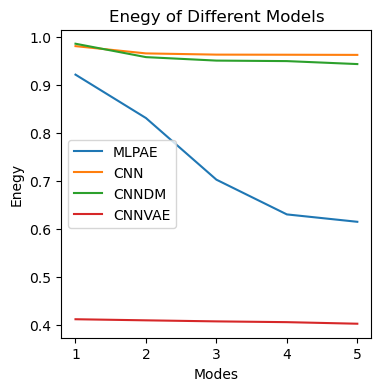

In [159]:

x = np.arange(1,6)
plt.figure(figsize=(4,4))
plt.plot(x, MLP_scores, label='MLPAE')
plt.plot(x, CNN_scores, label='CNNAE')
plt.plot(x, CNNDM_scores, label='CNNDM')
plt.plot(x, CNNVAE_scores, label='CNNVAE')
plt.legend()
plt.title('Enegy of Different Models')
plt.xlabel('Modes')
plt.ylabel('Enegy')
plt.savefig('/home/dylan/repo/10617Project/results/physical/output/energy.png')
plt.show()
plt.close()

In [ ]:
#

In [160]:
# Singular Value Plot

MLP_c = np.cov(MLPAE_z, rowvar=False)
MLP_u, MLP_d, MLP_v = np.linalg.svd(MLP_c)
MLP_d = MLP_d / MLP_d[0]

    
CNN_c = np.cov(CNN_z, rowvar=False)
CNN_u, CNN_d, CNN_v = np.linalg.svd(CNN_c)
CNN_d = CNN_d / CNN_d[0]

CNNDM_c = np.cov(CNNDM_z, rowvar=False)
CNNDM_u, CNNDM_d, CNNDM_v = np.linalg.svd(CNNDM_c)
CNNDM_d = CNNDM_d / CNNDM_d[0]

CNNVAE_c = np.cov(CNNVAE_z, rowvar=False)
CNNVAE_u, CNNVAE_d, CNNVAE_v = np.linalg.svd(CNNVAE_c)
CNNVAE_d = CNNVAE_d / CNNVAE_d[0]





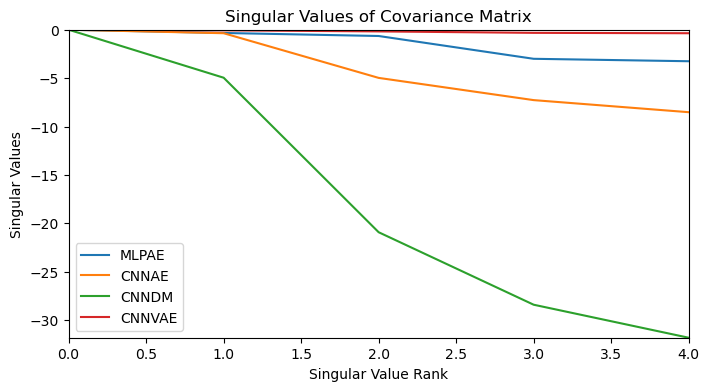

In [168]:
plt.figure(figsize=(8,4))
plt.plot(range(5), np.log(MLP_d), label='MLPAE')
plt.plot(range(5), np.log(CNN_d), label='CNNAE')
plt.plot(range(5), np.log(CNNDM_d), label='CNNDM')
plt.plot(range(5), np.log(CNNVAE_d), label='CNNVAE')
plt.legend()
plt.autoscale(enable=True, axis='y', tight=True)
plt.autoscale(enable=True, axis='x', tight=True)
#plt.ylim(0, 1)
#plt.xlim(0, args.latent_dim)
plt.xlabel("Singular Value Rank")
plt.ylabel("Singular Values")
plt.title(f"Singular Values of Covariance Matrix")
plt.savefig(f'/home/dylan/repo/10617Project/results/physical/output/singular_value')
plt.show()
plt.close()

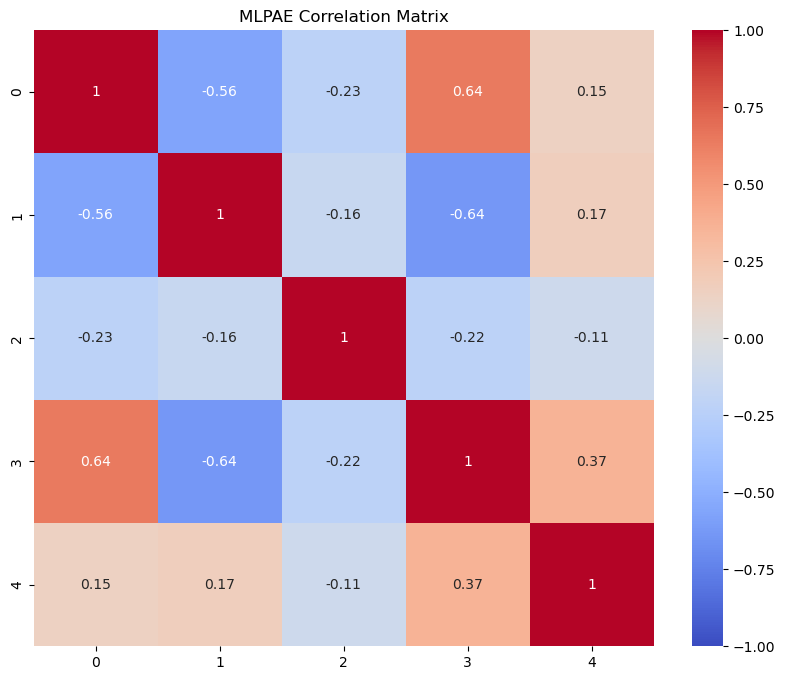

In [173]:
import seaborn as sns
## Correlation Matrix
z_hat = MLPAE_z
#np.save(f'/home/dylan/repo/10617Project/results/physical/latent/z_hat_{model.__class__.__name__}_{args.notes}_{args.latent_dim}.npy', z_hat)
df = pd.DataFrame(z_hat)
corr_matrix = df.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title(f"MLPAE Correlation Matrix")
plt.savefig(f'/home/dylan/repo/10617Project/results/physical/singular/corr_matrix_{model.__class__.__name__}_{args.notes}_{args.latent_dim}.png')
plt.show()
plt.close()
    

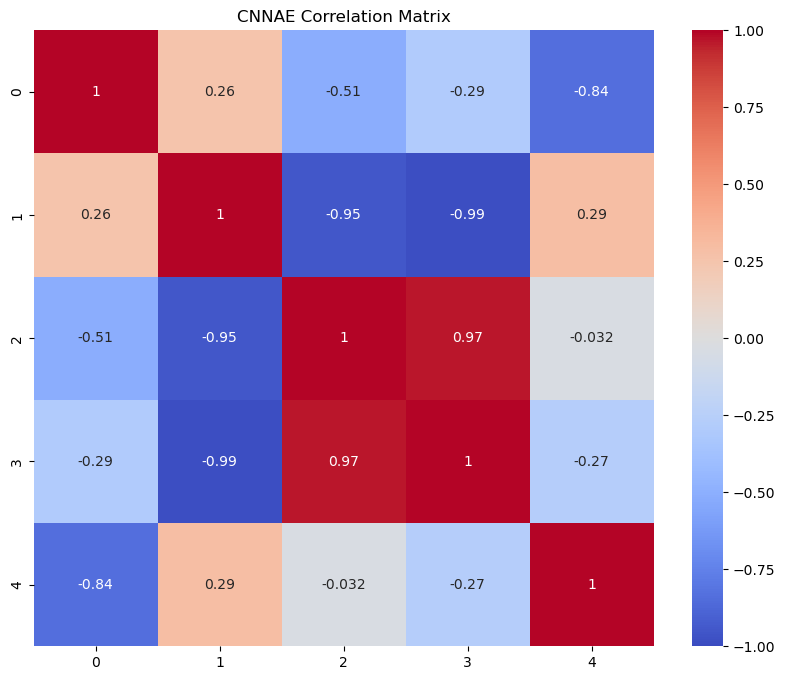

In [172]:
import seaborn as sns
## Correlation Matrix
z_hat = CNN_z
#np.save(f'/home/dylan/repo/10617Project/results/physical/latent/z_hat_{model.__class__.__name__}_{args.notes}_{args.latent_dim}.npy', z_hat)
df = pd.DataFrame(z_hat)
corr_matrix = df.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title(f"CNNAE Correlation Matrix")
#plt.savefig(f'/home/dylan/repo/10617Project/results/physical/singular/corr_matrix_{model.__class__.__name__}_{args.notes}_{args.latent_dim}.png')
plt.show()
plt.close()
    

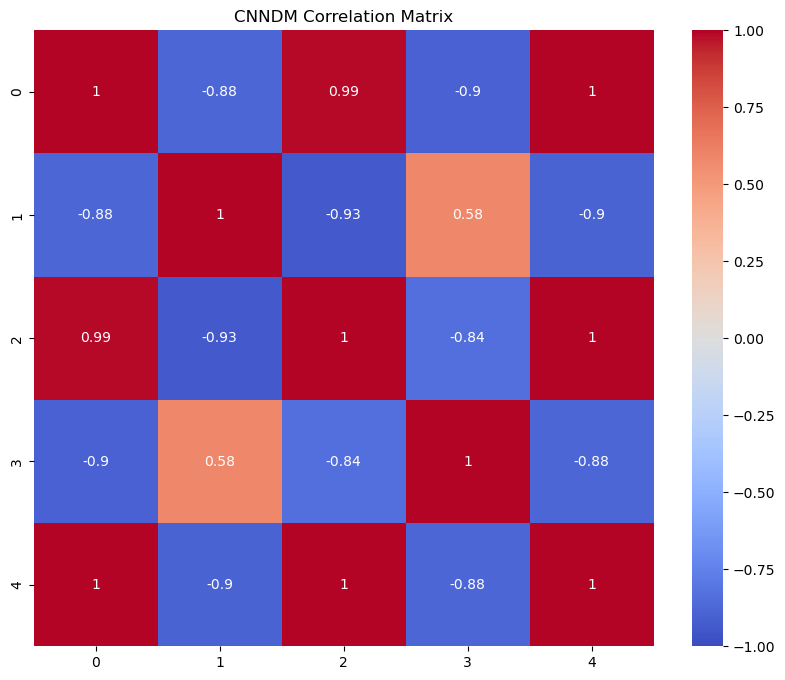

In [174]:
import seaborn as sns
## Correlation Matrix
z_hat = CNNDM_z
#np.save(f'/home/dylan/repo/10617Project/results/physical/latent/z_hat_{model.__class__.__name__}_{args.notes}_{args.latent_dim}.npy', z_hat)
df = pd.DataFrame(z_hat)
corr_matrix = df.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title(f"CNNDM Correlation Matrix")
plt.savefig(f'/home/dylan/repo/10617Project/results/physical/singular/corr_matrix_{model.__class__.__name__}_{args.notes}_{args.latent_dim}.png')
plt.show()
plt.close()

In [175]:
import seaborn as sns
## Correlation Matrix
z_hat_CNNDM = CNNDM_z
z_hat_CNN = CNN_z
z_hat_MLPAE  = MLPAE_z
z_hat_CNNVAE = CNNVAE_z


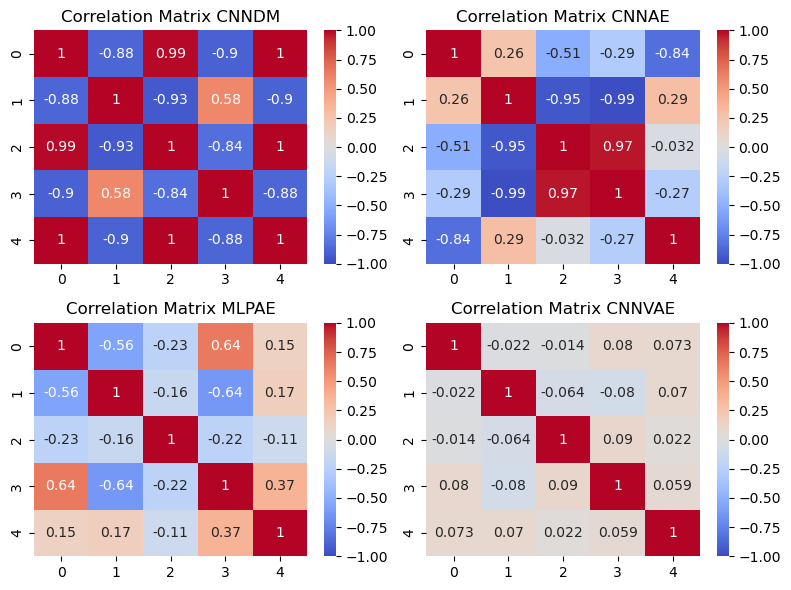

In [183]:
#np.save(f'/home/dylan/repo/10617Project/results/physical/latent/z_hat_{model.__class__.__name__}_{args.notes}_{args.latent_dim}.npy', z_hat)
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Sample dataframes - replace these with your actual data
df1 = pd.DataFrame(z_hat_CNNDM)
df2 = pd.DataFrame(z_hat_CNN)
df3 = pd.DataFrame(z_hat_MLPAE)
df4 = pd.DataFrame(z_hat_CNNVAE)

# Create a list of dataframes
names = ['CNNDM', 'CNNAE', 'MLPAE', 'CNNVAE']
dfs = [df1, df2, df3, df4]

# Create a 2x2 grid of subplots
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(8, 6))

# Flatten the axes array for easy indexing
axes = axes.flatten()

for i, df in enumerate(dfs):
    # Compute the correlation matrix for each dataframe
    corr_matrix = df.corr()

    # Plot the heatmap in the respective subplot
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, ax=axes[i])
    axes[i].set_title(f"Correlation Matrix {names[i]}")

# Adjust the layout
plt.tight_layout()

# Save the figure
plt.savefig(f'/home/dylan/repo/10617Project/results/physical/output/corr_matrices.png')

# Show the plot
plt.show()

# Close the plot
plt.close()
